Direct Preference Optimization (DPO):
Directly optimizes LLM based on user preferences.

In [1]:
import triton
import os 
import requests
import multiprocessing
import tarfile 
import pandas as pd 
import matplotlib.pyplot as plt 
import torch 
from datasets import load_dataset
from peft import LoraConfig
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, GPT2Tokenizer, set_seed, GenerationConfig, BitsAndBytesConfig
from trl import DPOConfig, DPOTrainer

c:\Users\mahat\anaconda3\envs\llm\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_id = "gpt2"
dataset_id = "BarraHome/ultrafeedback_binarized" # Collection of prompts and responses

In [3]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True, # Load the model in 4-bit quantized format
    bnb_4bit_use_double_quant=True, # Enable double quantization for better accuracy
    bnb_4bit_quant_type="nf4", # Use non-uniform 4-bit quantization (nf4)
    bnb_4bit_compute_dtype=torch.bfloat16 # Use bfloat16 as the computation data typ
)

model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=quantization_config)
reference_model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=quantization_config)
tokenizer = GPT2Tokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token 
tokenizer.padding_side = "right"
model.config.use_cache = False 

`low_cpu_mem_usage` was None, now default to True since model is quantized.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


In [4]:
for name, param in model.named_parameters():
    print(f"{name}: {param.numel()/1e6} million")

transformer.wte.weight: 38.597376 million
transformer.wpe.weight: 0.786432 million
transformer.h.0.ln_1.weight: 0.000768 million
transformer.h.0.ln_1.bias: 0.000768 million
transformer.h.0.attn.c_attn.weight: 0.884736 million
transformer.h.0.attn.c_attn.bias: 0.002304 million
transformer.h.0.attn.c_proj.weight: 0.294912 million
transformer.h.0.attn.c_proj.bias: 0.000768 million
transformer.h.0.ln_2.weight: 0.000768 million
transformer.h.0.ln_2.bias: 0.000768 million
transformer.h.0.mlp.c_fc.weight: 1.179648 million
transformer.h.0.mlp.c_fc.bias: 0.003072 million
transformer.h.0.mlp.c_proj.weight: 1.179648 million
transformer.h.0.mlp.c_proj.bias: 0.000768 million
transformer.h.1.ln_1.weight: 0.000768 million
transformer.h.1.ln_1.bias: 0.000768 million
transformer.h.1.attn.c_attn.weight: 0.884736 million
transformer.h.1.attn.c_attn.bias: 0.002304 million
transformer.h.1.attn.c_proj.weight: 0.294912 million
transformer.h.1.attn.c_proj.bias: 0.000768 million
transformer.h.1.ln_2.weight: 0.

In [5]:
dataset = load_dataset(dataset_id)
print(dataset)
print(dataset["train_prefs"][0])

DatasetDict({
    train_prefs: Dataset({
        features: ['prompt', 'prompt_id', 'chosen', 'rejected', 'messages', 'score_chosen', 'score_rejected'],
        num_rows: 61135
    })
    train_sft: Dataset({
        features: ['prompt', 'prompt_id', 'chosen', 'rejected', 'messages', 'score_chosen', 'score_rejected'],
        num_rows: 61135
    })
    test_prefs: Dataset({
        features: ['prompt', 'prompt_id', 'chosen', 'rejected', 'messages', 'score_chosen', 'score_rejected'],
        num_rows: 2000
    })
    test_sft: Dataset({
        features: ['prompt', 'prompt_id', 'chosen', 'rejected', 'messages', 'score_chosen', 'score_rejected'],
        num_rows: 1000
    })
    train_gen: Dataset({
        features: ['prompt', 'prompt_id', 'chosen', 'rejected', 'messages', 'score_chosen', 'score_rejected'],
        num_rows: 61135
    })
    test_gen: Dataset({
        features: ['prompt', 'prompt_id', 'chosen', 'rejected', 'messages', 'score_chosen', 'score_rejected'],
        num_rows

In [6]:
del dataset["train_gen"]
del dataset["test_gen"]
del dataset["train_sft"]
del dataset["test_sft"]

print(dataset)

def process_data(row):
    del row["prompt_id"]
    del row["messages"]
    del row["score_chosen"]
    del row["score_rejected"]

    row["chosen"] = row["chosen"][-1]["content"]
    row["rejected"] = row["rejected"][-1]["content"]

    return row

dataset = dataset.map(process_data, num_proc=multiprocessing.cpu_count()-4, load_from_cache_file=False)

DatasetDict({
    train_prefs: Dataset({
        features: ['prompt', 'prompt_id', 'chosen', 'rejected', 'messages', 'score_chosen', 'score_rejected'],
        num_rows: 61135
    })
    test_prefs: Dataset({
        features: ['prompt', 'prompt_id', 'chosen', 'rejected', 'messages', 'score_chosen', 'score_rejected'],
        num_rows: 2000
    })
})


Map (num_proc=28): 100%|██████████| 2000/2000 [00:07<00:00, 252.18 examples/s]


In [7]:
train_dataset = dataset["train_prefs"]
test_dataset = dataset["test_prefs"]

In [8]:
lora_config = LoraConfig(
    r=32,
    lora_alpha=16,
    lora_dropout=0.05,
    target_modules=["c_proj", "c_attn"],
    task_type="CAUSAL_LM"
)

training_args = DPOConfig(
    beta=0.1, # beta is the temperature parameter for the DPO loss, typically something in the range of 0.1 to 0.5
    output_dir="rlhf_dpo",
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=1,
    learning_rate=1e-4,
    warmup_steps=2,
    remove_unused_columns=False,
    logging_steps=1024,
    eval_strategy="steps",
    eval_steps=1024,
    save_strategy="epoch",
    fp16=True,
    max_length=512,
    max_prompt_length=512,
    report_to="none"
)

In [9]:
tokenizer.pad_token = tokenizer.eos_token

trainer = DPOTrainer(
    model,
    ref_model=None, # when using LoRA for the base model, it's efficient to leave the model_ref param null, in which case the DPOTrainer will unload the adapter for reference inference
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    peft_config=lora_config, 
    tokenizer=tokenizer,
)

C:\Users\mahat\AppData\Local\Temp\ipykernel_60504\3757377428.py:3: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `DPOTrainer.__init__`. Use `processing_class` instead.
  trainer = DPOTrainer(


In [10]:
trainer.train()

  7%|▋         | 1024/15284 [04:52<1:07:25,  3.53it/s]

{'loss': 0.6666, 'grad_norm': 2.2434146404266357, 'learning_rate': 9.333202460410942e-05, 'rewards/chosen': 0.5668275356292725, 'rewards/rejected': 0.3386619985103607, 'rewards/accuracies': 0.5625, 'rewards/margins': 0.22816552221775055, 'logps/chosen': -523.795166015625, 'logps/rejected': -451.5306701660156, 'logits/chosen': -102.09928131103516, 'logits/rejected': -103.06541442871094, 'epoch': 0.13}


                                                      
  7%|▋         | 1024/15284 [05:33<1:07:25,  3.53it/s]

{'eval_loss': 0.6738049387931824, 'eval_runtime': 40.9999, 'eval_samples_per_second': 48.781, 'eval_steps_per_second': 6.098, 'eval_rewards/chosen': 0.553997278213501, 'eval_rewards/rejected': 0.2818065881729126, 'eval_rewards/accuracies': 0.5870000123977661, 'eval_rewards/margins': 0.2721906900405884, 'eval_logps/chosen': -534.041748046875, 'eval_logps/rejected': -472.54705810546875, 'eval_logits/chosen': -103.0593032836914, 'eval_logits/rejected': -102.42581176757812, 'epoch': 0.13}


 13%|█▎        | 2048/15284 [10:25<1:03:12,  3.49it/s] 

{'loss': 0.6577, 'grad_norm': 0.8898564577102661, 'learning_rate': 8.663133097762074e-05, 'rewards/chosen': 0.598515510559082, 'rewards/rejected': 0.30062156915664673, 'rewards/accuracies': 0.5821533203125, 'rewards/margins': 0.2978939414024353, 'logps/chosen': -522.191650390625, 'logps/rejected': -461.50274658203125, 'logits/chosen': -100.46903228759766, 'logits/rejected': -101.26806640625, 'epoch': 0.27}


                                                      
 13%|█▎        | 2048/15284 [11:06<1:03:12,  3.49it/s]

{'eval_loss': 0.665461003780365, 'eval_runtime': 40.8019, 'eval_samples_per_second': 49.017, 'eval_steps_per_second': 6.127, 'eval_rewards/chosen': 0.48388123512268066, 'eval_rewards/rejected': 0.19778943061828613, 'eval_rewards/accuracies': 0.5945000052452087, 'eval_rewards/margins': 0.28609180450439453, 'eval_logps/chosen': -534.742919921875, 'eval_logps/rejected': -473.38720703125, 'eval_logits/chosen': -101.17411041259766, 'eval_logits/rejected': -100.5389175415039, 'epoch': 0.27}


 20%|██        | 3072/15284 [15:56<57:35,  3.53it/s]   

{'loss': 0.6539, 'grad_norm': 1.0178676843643188, 'learning_rate': 7.993718099725167e-05, 'rewards/chosen': 0.631892740726471, 'rewards/rejected': 0.3226603865623474, 'rewards/accuracies': 0.5863037109375, 'rewards/margins': 0.3092324137687683, 'logps/chosen': -527.9558715820312, 'logps/rejected': -459.2731018066406, 'logits/chosen': -100.3353500366211, 'logits/rejected': -101.06554412841797, 'epoch': 0.4}


                                                    
 20%|██        | 3072/15284 [16:37<57:35,  3.53it/s]

{'eval_loss': 0.6434981226921082, 'eval_runtime': 40.779, 'eval_samples_per_second': 49.045, 'eval_steps_per_second': 6.131, 'eval_rewards/chosen': 0.6850810647010803, 'eval_rewards/rejected': 0.387647807598114, 'eval_rewards/accuracies': 0.6039999723434448, 'eval_rewards/margins': 0.2974332273006439, 'eval_logps/chosen': -532.73095703125, 'eval_logps/rejected': -471.4886169433594, 'eval_logits/chosen': -100.76449584960938, 'eval_logits/rejected': -100.1197509765625, 'epoch': 0.4}


 27%|██▋       | 4096/15284 [21:41<56:33,  3.30it/s]   

{'loss': 0.6436, 'grad_norm': 0.8770841360092163, 'learning_rate': 7.3236487370763e-05, 'rewards/chosen': 0.6246670484542847, 'rewards/rejected': 0.28672462701797485, 'rewards/accuracies': 0.5904541015625, 'rewards/margins': 0.3379424512386322, 'logps/chosen': -527.9288330078125, 'logps/rejected': -464.8879699707031, 'logits/chosen': -100.01171112060547, 'logits/rejected': -100.05595397949219, 'epoch': 0.54}


                                                    
 27%|██▋       | 4096/15284 [22:26<56:33,  3.30it/s]

{'eval_loss': 0.6547531485557556, 'eval_runtime': 45.1424, 'eval_samples_per_second': 44.304, 'eval_steps_per_second': 5.538, 'eval_rewards/chosen': 0.5218600034713745, 'eval_rewards/rejected': 0.19143404066562653, 'eval_rewards/accuracies': 0.6069999933242798, 'eval_rewards/margins': 0.3304259777069092, 'eval_logps/chosen': -534.3630981445312, 'eval_logps/rejected': -473.4508056640625, 'eval_logits/chosen': -100.51679229736328, 'eval_logits/rejected': -99.89582824707031, 'epoch': 0.54}


 33%|███▎      | 5120/15284 [27:42<52:12,  3.24it/s]   

{'loss': 0.6359, 'grad_norm': 0.6306087374687195, 'learning_rate': 6.654233739039393e-05, 'rewards/chosen': 0.6611647605895996, 'rewards/rejected': 0.2733622193336487, 'rewards/accuracies': 0.5994873046875, 'rewards/margins': 0.38780251145362854, 'logps/chosen': -530.8432006835938, 'logps/rejected': -467.0559997558594, 'logits/chosen': -99.02348327636719, 'logits/rejected': -99.71822357177734, 'epoch': 0.67}


                                                    
 33%|███▎      | 5120/15284 [28:27<52:12,  3.24it/s]

{'eval_loss': 0.6413285136222839, 'eval_runtime': 44.6929, 'eval_samples_per_second': 44.75, 'eval_steps_per_second': 5.594, 'eval_rewards/chosen': 0.5712413191795349, 'eval_rewards/rejected': 0.2030525803565979, 'eval_rewards/accuracies': 0.609000027179718, 'eval_rewards/margins': 0.3681887090206146, 'eval_logps/chosen': -533.8693237304688, 'eval_logps/rejected': -473.3346252441406, 'eval_logits/chosen': -99.38443756103516, 'eval_logits/rejected': -98.7081527709961, 'epoch': 0.67}


 40%|████      | 6144/15284 [33:39<46:41,  3.26it/s]   

{'loss': 0.6385, 'grad_norm': 1.4567480087280273, 'learning_rate': 5.984164376390525e-05, 'rewards/chosen': 0.6533321142196655, 'rewards/rejected': 0.2836838662624359, 'rewards/accuracies': 0.5977783203125, 'rewards/margins': 0.3696483373641968, 'logps/chosen': -522.2119750976562, 'logps/rejected': -460.3009338378906, 'logits/chosen': -99.8340835571289, 'logits/rejected': -100.17364501953125, 'epoch': 0.8}


                                                    
 40%|████      | 6144/15284 [34:22<46:41,  3.26it/s]

{'eval_loss': 0.629112184047699, 'eval_runtime': 42.957, 'eval_samples_per_second': 46.558, 'eval_steps_per_second': 5.82, 'eval_rewards/chosen': 0.616790235042572, 'eval_rewards/rejected': 0.28725865483283997, 'eval_rewards/accuracies': 0.6140000224113464, 'eval_rewards/margins': 0.32953158020973206, 'eval_logps/chosen': -533.413818359375, 'eval_logps/rejected': -472.4925231933594, 'eval_logits/chosen': -100.20228576660156, 'eval_logits/rejected': -99.48692321777344, 'epoch': 0.8}


 47%|████▋     | 7168/15284 [39:31<41:19,  3.27it/s]   

{'loss': 0.6322, 'grad_norm': 1.1198220252990723, 'learning_rate': 5.314095013741657e-05, 'rewards/chosen': 0.6151527166366577, 'rewards/rejected': 0.24915823340415955, 'rewards/accuracies': 0.5963134765625, 'rewards/margins': 0.3659944534301758, 'logps/chosen': -521.4160766601562, 'logps/rejected': -461.8245849609375, 'logits/chosen': -99.83357238769531, 'logits/rejected': -99.88917541503906, 'epoch': 0.94}


                                                    
 47%|████▋     | 7168/15284 [40:16<41:19,  3.27it/s]

{'eval_loss': 0.6400429606437683, 'eval_runtime': 44.9386, 'eval_samples_per_second': 44.505, 'eval_steps_per_second': 5.563, 'eval_rewards/chosen': 0.7642728686332703, 'eval_rewards/rejected': 0.3796665668487549, 'eval_rewards/accuracies': 0.612500011920929, 'eval_rewards/margins': 0.38460633158683777, 'eval_logps/chosen': -531.9390258789062, 'eval_logps/rejected': -471.5684509277344, 'eval_logits/chosen': -100.6396713256836, 'eval_logits/rejected': -99.96453857421875, 'epoch': 0.94}


 54%|█████▎    | 8192/15284 [45:24<35:31,  3.33it/s]   

{'loss': 0.6093, 'grad_norm': 0.7903600931167603, 'learning_rate': 4.644680015704751e-05, 'rewards/chosen': 0.6189964413642883, 'rewards/rejected': 0.18092316389083862, 'rewards/accuracies': 0.6203439235687256, 'rewards/margins': 0.4380732774734497, 'logps/chosen': -525.3156127929688, 'logps/rejected': -464.1519775390625, 'logits/chosen': -99.55381774902344, 'logits/rejected': -99.99031066894531, 'epoch': 1.07}


                                                    
 54%|█████▎    | 8192/15284 [46:09<35:31,  3.33it/s]

{'eval_loss': 0.6391516923904419, 'eval_runtime': 44.5124, 'eval_samples_per_second': 44.931, 'eval_steps_per_second': 5.616, 'eval_rewards/chosen': 0.7158070802688599, 'eval_rewards/rejected': 0.30814048647880554, 'eval_rewards/accuracies': 0.6175000071525574, 'eval_rewards/margins': 0.40766656398773193, 'eval_logps/chosen': -532.4237060546875, 'eval_logps/rejected': -472.28375244140625, 'eval_logits/chosen': -100.11885833740234, 'eval_logits/rejected': -99.38455200195312, 'epoch': 1.07}


 60%|██████    | 9216/15284 [51:10<30:37,  3.30it/s]   

{'loss': 0.5734, 'grad_norm': 0.8657245635986328, 'learning_rate': 3.974610653055883e-05, 'rewards/chosen': 0.7672197818756104, 'rewards/rejected': 0.2021065056324005, 'rewards/accuracies': 0.6446533203125, 'rewards/margins': 0.5651132464408875, 'logps/chosen': -525.6060791015625, 'logps/rejected': -463.8431091308594, 'logits/chosen': -99.1603012084961, 'logits/rejected': -99.52011108398438, 'epoch': 1.21}


                                                    
 60%|██████    | 9216/15284 [51:54<30:37,  3.30it/s]

{'eval_loss': 0.6487426161766052, 'eval_runtime': 44.754, 'eval_samples_per_second': 44.689, 'eval_steps_per_second': 5.586, 'eval_rewards/chosen': 0.7617883086204529, 'eval_rewards/rejected': 0.3443501591682434, 'eval_rewards/accuracies': 0.6165000200271606, 'eval_rewards/margins': 0.41743817925453186, 'eval_logps/chosen': -531.9638671875, 'eval_logps/rejected': -471.921630859375, 'eval_logits/chosen': -99.53913879394531, 'eval_logits/rejected': -98.88516998291016, 'epoch': 1.21}


 67%|██████▋   | 10240/15284 [57:06<25:48,  3.26it/s]  

{'loss': 0.5788, 'grad_norm': 1.1960644721984863, 'learning_rate': 3.3051956550189764e-05, 'rewards/chosen': 0.7094880938529968, 'rewards/rejected': 0.17501014471054077, 'rewards/accuracies': 0.6502685546875, 'rewards/margins': 0.5344778299331665, 'logps/chosen': -522.6973876953125, 'logps/rejected': -461.3839416503906, 'logits/chosen': -99.15031433105469, 'logits/rejected': -99.7960433959961, 'epoch': 1.34}


                                                     
 67%|██████▋   | 10240/15284 [57:51<25:48,  3.26it/s]

{'eval_loss': 0.635769248008728, 'eval_runtime': 45.5911, 'eval_samples_per_second': 43.868, 'eval_steps_per_second': 5.484, 'eval_rewards/chosen': 0.5592180490493774, 'eval_rewards/rejected': 0.1594666987657547, 'eval_rewards/accuracies': 0.6110000014305115, 'eval_rewards/margins': 0.3997514247894287, 'eval_logps/chosen': -533.9895629882812, 'eval_logps/rejected': -473.7704772949219, 'eval_logits/chosen': -99.92675018310547, 'eval_logits/rejected': -99.23161315917969, 'epoch': 1.34}


 74%|███████▎  | 11264/15284 [1:02:55<19:35,  3.42it/s] 

{'loss': 0.5703, 'grad_norm': 0.9191356897354126, 'learning_rate': 2.6357806569820704e-05, 'rewards/chosen': 0.7477261424064636, 'rewards/rejected': 0.1664568930864334, 'rewards/accuracies': 0.6494140625, 'rewards/margins': 0.5812692642211914, 'logps/chosen': -521.810546875, 'logps/rejected': -457.99127197265625, 'logits/chosen': -98.65650939941406, 'logits/rejected': -99.46604919433594, 'epoch': 1.47}


                                                       
 74%|███████▎  | 11264/15284 [1:03:41<19:35,  3.42it/s]

{'eval_loss': 0.6363370418548584, 'eval_runtime': 45.1876, 'eval_samples_per_second': 44.26, 'eval_steps_per_second': 5.532, 'eval_rewards/chosen': 0.7083479762077332, 'eval_rewards/rejected': 0.2583220601081848, 'eval_rewards/accuracies': 0.6159999966621399, 'eval_rewards/margins': 0.45002591609954834, 'eval_logps/chosen': -532.4982299804688, 'eval_logps/rejected': -472.7819519042969, 'eval_logits/chosen': -99.42627716064453, 'eval_logits/rejected': -98.78097534179688, 'epoch': 1.47}


 80%|████████  | 12288/15284 [1:08:51<15:15,  3.27it/s]   

{'loss': 0.5684, 'grad_norm': 1.8063570261001587, 'learning_rate': 1.9657112943332026e-05, 'rewards/chosen': 0.7454993724822998, 'rewards/rejected': 0.13500003516674042, 'rewards/accuracies': 0.639892578125, 'rewards/margins': 0.610499382019043, 'logps/chosen': -519.1068725585938, 'logps/rejected': -461.06927490234375, 'logits/chosen': -98.93470764160156, 'logits/rejected': -99.37032318115234, 'epoch': 1.61}


                                                       
 80%|████████  | 12288/15284 [1:09:36<15:15,  3.27it/s]

{'eval_loss': 0.6357757449150085, 'eval_runtime': 45.7739, 'eval_samples_per_second': 43.693, 'eval_steps_per_second': 5.462, 'eval_rewards/chosen': 0.6311261057853699, 'eval_rewards/rejected': 0.20661060512065887, 'eval_rewards/accuracies': 0.6134999990463257, 'eval_rewards/margins': 0.4245154857635498, 'eval_logps/chosen': -533.2705078125, 'eval_logps/rejected': -473.2990417480469, 'eval_logits/chosen': -99.66893768310547, 'eval_logits/rejected': -99.0103759765625, 'epoch': 1.61}


 87%|████████▋ | 13312/15284 [1:14:37<10:05,  3.26it/s]   

{'loss': 0.5702, 'grad_norm': 2.2830560207366943, 'learning_rate': 1.2956419316843347e-05, 'rewards/chosen': 0.7310353517532349, 'rewards/rejected': 0.16219407320022583, 'rewards/accuracies': 0.651611328125, 'rewards/margins': 0.5688412189483643, 'logps/chosen': -526.0047607421875, 'logps/rejected': -463.54046630859375, 'logits/chosen': -98.82339477539062, 'logits/rejected': -99.51535034179688, 'epoch': 1.74}


                                                       
 87%|████████▋ | 13312/15284 [1:15:22<10:05,  3.26it/s]

{'eval_loss': 0.6305416226387024, 'eval_runtime': 44.8787, 'eval_samples_per_second': 44.565, 'eval_steps_per_second': 5.571, 'eval_rewards/chosen': 0.711168646812439, 'eval_rewards/rejected': 0.26878729462623596, 'eval_rewards/accuracies': 0.6165000200271606, 'eval_rewards/margins': 0.442381352186203, 'eval_logps/chosen': -532.4700927734375, 'eval_logps/rejected': -472.6772155761719, 'eval_logits/chosen': -99.26005554199219, 'eval_logits/rejected': -98.60610961914062, 'epoch': 1.74}


 94%|█████████▍| 14336/15284 [1:20:39<04:57,  3.18it/s]  

{'loss': 0.5617, 'grad_norm': 2.920980453491211, 'learning_rate': 6.255725690354666e-06, 'rewards/chosen': 0.7734643220901489, 'rewards/rejected': 0.1617281436920166, 'rewards/accuracies': 0.657470703125, 'rewards/margins': 0.6117361187934875, 'logps/chosen': -519.816162109375, 'logps/rejected': -462.2753601074219, 'logits/chosen': -98.43195343017578, 'logits/rejected': -99.03311157226562, 'epoch': 1.88}


                                                       
 94%|█████████▍| 14336/15284 [1:21:26<04:57,  3.18it/s]

{'eval_loss': 0.6327923536300659, 'eval_runtime': 46.507, 'eval_samples_per_second': 43.004, 'eval_steps_per_second': 5.376, 'eval_rewards/chosen': 0.6823931336402893, 'eval_rewards/rejected': 0.22563405334949493, 'eval_rewards/accuracies': 0.6144999861717224, 'eval_rewards/margins': 0.45675909519195557, 'eval_logps/chosen': -532.7577514648438, 'eval_logps/rejected': -473.10882568359375, 'eval_logits/chosen': -99.28807067871094, 'eval_logits/rejected': -98.6174087524414, 'epoch': 1.88}


100%|██████████| 15284/15284 [1:25:54<00:00,  2.97it/s]  

{'train_runtime': 5154.1721, 'train_samples_per_second': 23.723, 'train_steps_per_second': 2.965, 'train_loss': 0.6083756112141373, 'epoch': 2.0}


TrainOutput(global_step=15284, training_loss=0.6083756112141373, metrics={'train_runtime': 5154.1721, 'train_samples_per_second': 23.723, 'train_steps_per_second': 2.965, 'total_flos': 0.0, 'train_loss': 0.6083756112141373, 'epoch': 2.0})

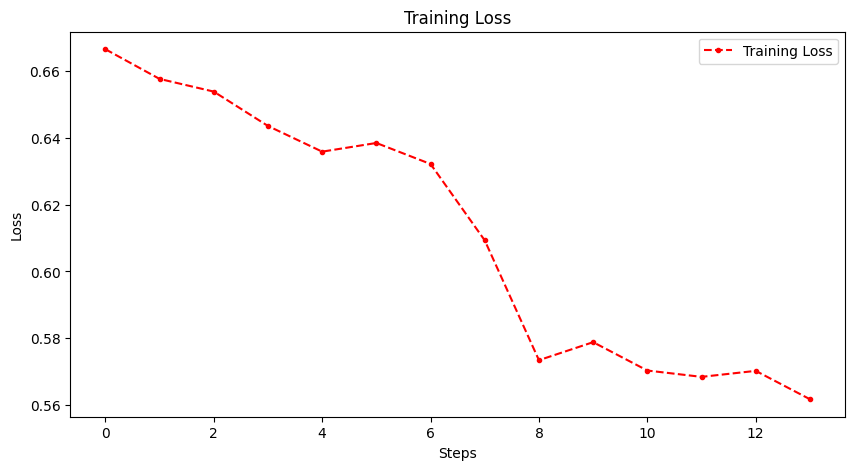

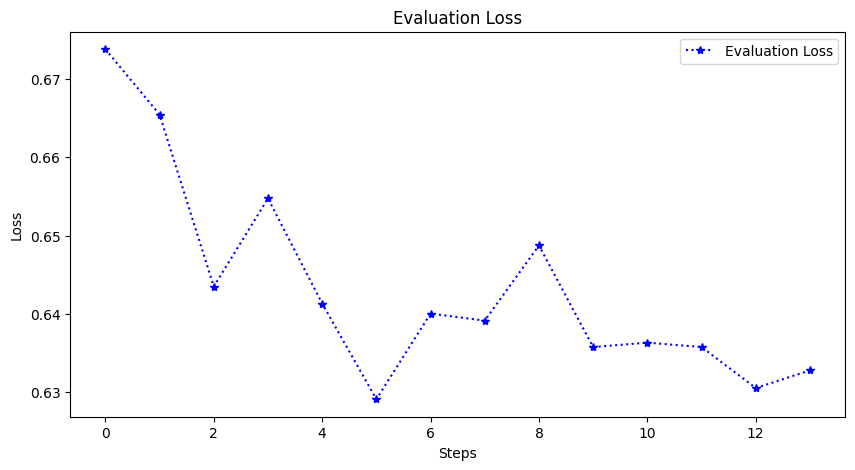

In [11]:
log_history_lora = trainer.state.log_history

train_loss = [log["loss"] for log in log_history_lora if "loss" in log]
eval_loss = [log["eval_loss"] for log in log_history_lora if "eval_loss" in log]

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss', marker='.', color='r', linestyle='--')

plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

# Plot the evaluation loss
plt.figure(figsize=(10, 5))
plt.plot(eval_loss, label='Evaluation Loss', marker='*', color='b', linestyle=':')

plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Evaluation Loss')
plt.legend()
plt.show()

Evaluating the fine-tuned model:

In [18]:
# Loading trained model
dpo_model = AutoModelForCausalLM.from_pretrained("rlhf_dpo/checkpoint-15284")
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

generation_config = GenerationConfig(
        do_sample=True, # Use sampling to generate diverse text
        top_k=1, # Top-k sampling parameter
        temperature=0.1, # Controls the randomness of the generated text
        max_new_tokens=32, # Maximum number of new tokens to generate
        pad_token_id=tokenizer.eos_token_id
    )

# Loading trained model
gpt2_model = AutoModelForCausalLM.from_pretrained(model_id)

In [20]:
prompt = "Is a higher octane gasoline better for your car?"
print(f"Prompt: {prompt}")
print("#"*50)

inputs = tokenizer(prompt, return_tensors='pt')

outputs = dpo_model.generate(**inputs, generation_config=generation_config)
print("Response from Fine-tuned model using DPO:\n",tokenizer.decode(outputs[0], skip_special_tokens=True))
print("#"*50)

outputs = gpt2_model.generate(**inputs, generation_config=generation_config)
print("\nOriginal GPT2 model response:\n",tokenizer.decode(outputs[0], skip_special_tokens=True))
print("#"*50)

Prompt: Is a higher octane gasoline better for your car?
##################################################
Response from Fine-tuned model using DPO:
 Is a higher octane gasoline better for your car?

A: Yes, it is. The octane gasoline is a better fuel for your car. It is a better fuel for your car. It is
##################################################

Original GPT2 model response:
 Is a higher octane gasoline better for your car?

The answer is yes. The higher octane gasoline is more efficient and more fuel efficient.

The higher octane gasoline is more efficient and more
##################################################
